# Fitting SEDs with Builtin Models

This tutorial will walk you through using syncfit to model the data from Andreoni et al. (2022) on AT2022cmc for day 45.3 $\pm$ 5 days with two different builtin models. The data is provided in `AT2022cmc_Andreoni2022.txt`

First we need to import the modules we need for this tutorial:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import syncfit

Now we can read in the 2022cmc data and see what it looks like

In [2]:
# read in the data
cmc = pd.read_csv('AT2022cmc_Andreoni2022.txt')
cmc

,facility,date,dt,nu,F_nu,F_err,upperlimit
0,NOEMA,2022-03-24 22:14,41.48,86.0,3914,30,True
1,NOEMA,2022-03-24 22:14,41.48,102.0,3609,34,False
2,NOEMA,2022-03-25 00:45,41.58,136.0,3045,41,False
3,NOEMA,2022-03-25 00:45,41.58,152.0,2750,51,False
4,VLA,2022-03-31 04:08,47.73,31.4,2130,30,False
5,VLA,2022-03-31 04:08,47.73,33.5,2260,30,False
6,VLA,2022-03-31 04:08,47.73,35.6,2350,40,False
7,VLA,2022-03-31 04:08,47.73,37.5,2360,40,True
8,VLA,2022-03-31 04:13,47.73,8.5,270,12,False
9,VLA,2022-03-31 04:13,47.73,9.5,336,11,False


Text(0, 0.5, 'Flux [uJy]')

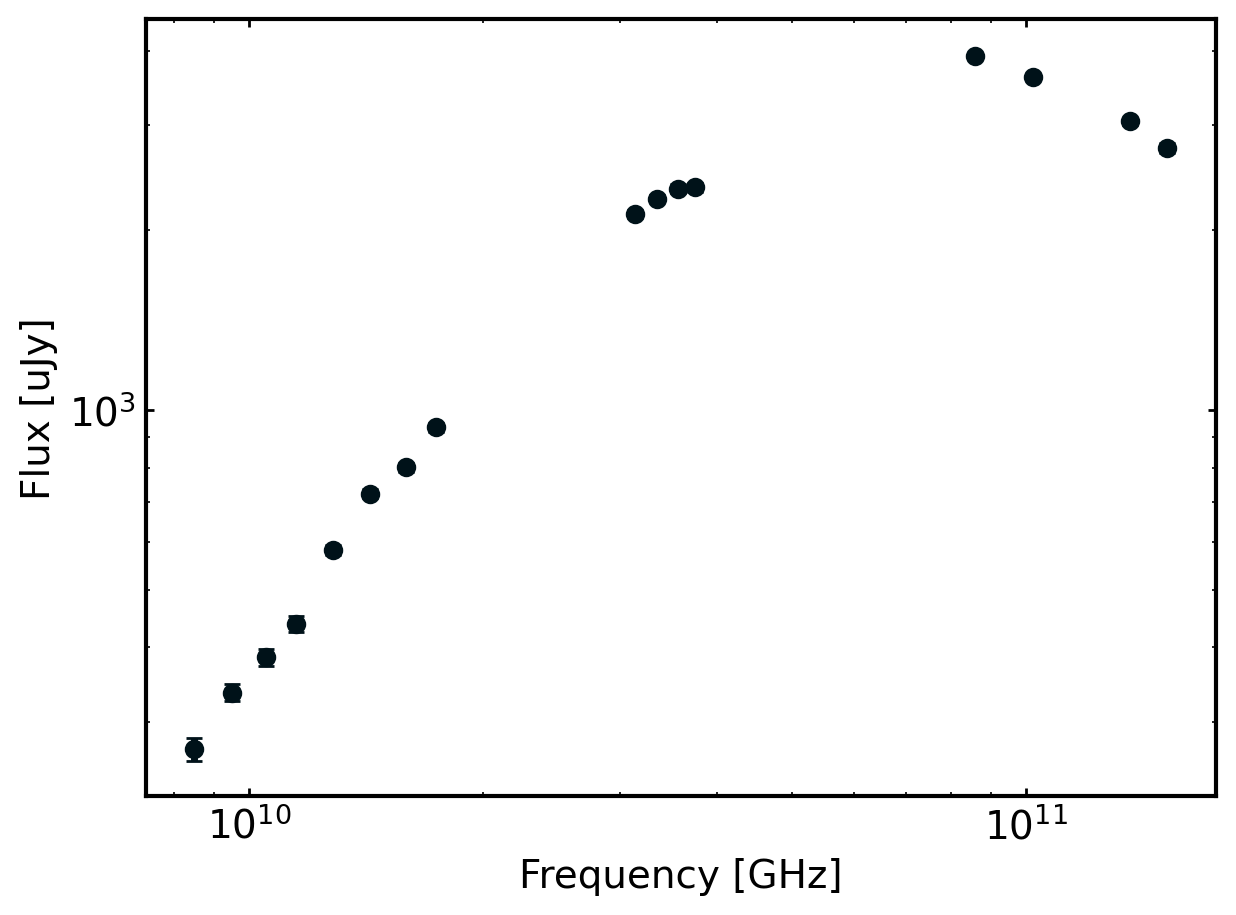

In [3]:
# now plot the SED
fig, ax = plt.subplots(1)

ax.errorbar(cmc.nu*1e9, cmc.F_nu, yerr=cmc.F_err, fmt='o')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Flux [uJy]')

## Fitting the SED

### Using the B5B3 model
The builtin B5B3 model to syncfit incorporates both a self-absorption break and cooling break. The peak of the above SED looks a little offset from what we might expect so it's worth starting with a B5B3 model. But, if we find that it is overfitting the data (spoiler alert: we will!) then we can back off the complexity of our fit (ie. reduce the number of breaks).

To fit the data, we need to use the `syncfit.do_emcee` method which takes the following arguments:


        theta_init (list) – array of initial guesses, must be the length expected by model

        nu (list) – list of frequencies in GHz

        F_muJy (list) – list of fluxes in micro janskies

        F_error (list) – list of flux error in micro janskies

        model (BaseModel) – Model class to use from syncfit.fitter.models. Can also be a custom model but it must be a subclass of BaseModel!

        niter (int) – The number of iterations to run on.

        nwalkers (int) – The number of walkers to use for emcee

        fix_p (float) – Will fix the p value to whatever you give, do not provide p in theta_init if this is the case!

        day (string) – day of observation, used for labeling plots

        plot (bool) – If True, generate the plots used for debugging. Default is False.
        
We have nu, F_muJy, F_error, and model (since we are using a default model) so we just need to specify some other emcee hyperparameters! 

`theta_init` is one of the most important ones since it needs to be the proper length. The length of this list will always be 2 + # of breaks if `fix_p=None` and 1 + # of breaks if `fix_p=p` where p is a p-value to fix to. 

The order of the values in `theta_init` are 
* for `fix_p=None`: initial p, initial logarithmic F_nu, initial nu guesses
* for `fix_p=p`: initial logarithmic F_nu, initial nu guesses

where the number of initial nu guesses changes depending on the model being used. For example, for B5B3, we have two breaks so there are two initial nu guesses in the order nu_a, nu_c. On the other hand, for B5, there is only one break so there is only one initial nu guess for nu_a.

In [4]:
# the initial guesses
theta_init = [
    3, # p-value guess
    0, # initial log_F_nu guess
    10, # initial nu_a guess
    11, # initial nu_c guess, must be larger than nu_a
]

# the number of walkers
# 32 is usually fine, more makes it slower! 
nwalkers = 32

# now define the number of iterations
# something small for now to make it fast, 
# usually ~2000 gives a converging chaing
niter = 500

# now we can fit the data
sampler = syncfit.do_emcee(
    theta_init = theta_init,
    nu = cmc.nu,
    F_muJy = cmc.F_nu,
    F_error = cmc.F_err,
    model = syncfit.models.B5B3, # get the model from syncfit
    niter = niter,
    nwalkers = nwalkers
)

 40%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 202/500 [00:00<00:00, 2019.52it/s]/home/nfranz/syncfit/src/syncfit/models/b5b3_model.py:31: RuntimeWarning: overflow encountered in scalar power
  nu_c = 10**log_nu_c
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2077.95it/s]


And now we can explore the output `sampler` using the `syncfit.analysis` module. First, let's look at the constraints it placed:

In [5]:
# get the chain labels from the model
labels = syncfit.models.B5B3.get_labels() 

constraints = syncfit.analysis.get_bounds(sampler, labels, toprint=True)

\mathrm{p} = 2.00e+00_{-0.003}^{0.680}
\mathrm{log F_v} = 8.23e-01_{-0.044}^{0.004}
\mathrm{log nu_a} = 1.05e+01_{-0.004}^{0.004}
\mathrm{log nu_c} = 3.10e+01_{-14.407}^{1471.467}


We can also look at the chain to see if it is converged:

(<Figure size 2000x1400 with 4 Axes>,
 array([<Axes: ylabel='p'>, <Axes: ylabel='log F_v'>,
        <Axes: ylabel='log nu_a'>,
        <Axes: xlabel='step number', ylabel='log nu_c'>], dtype=object))

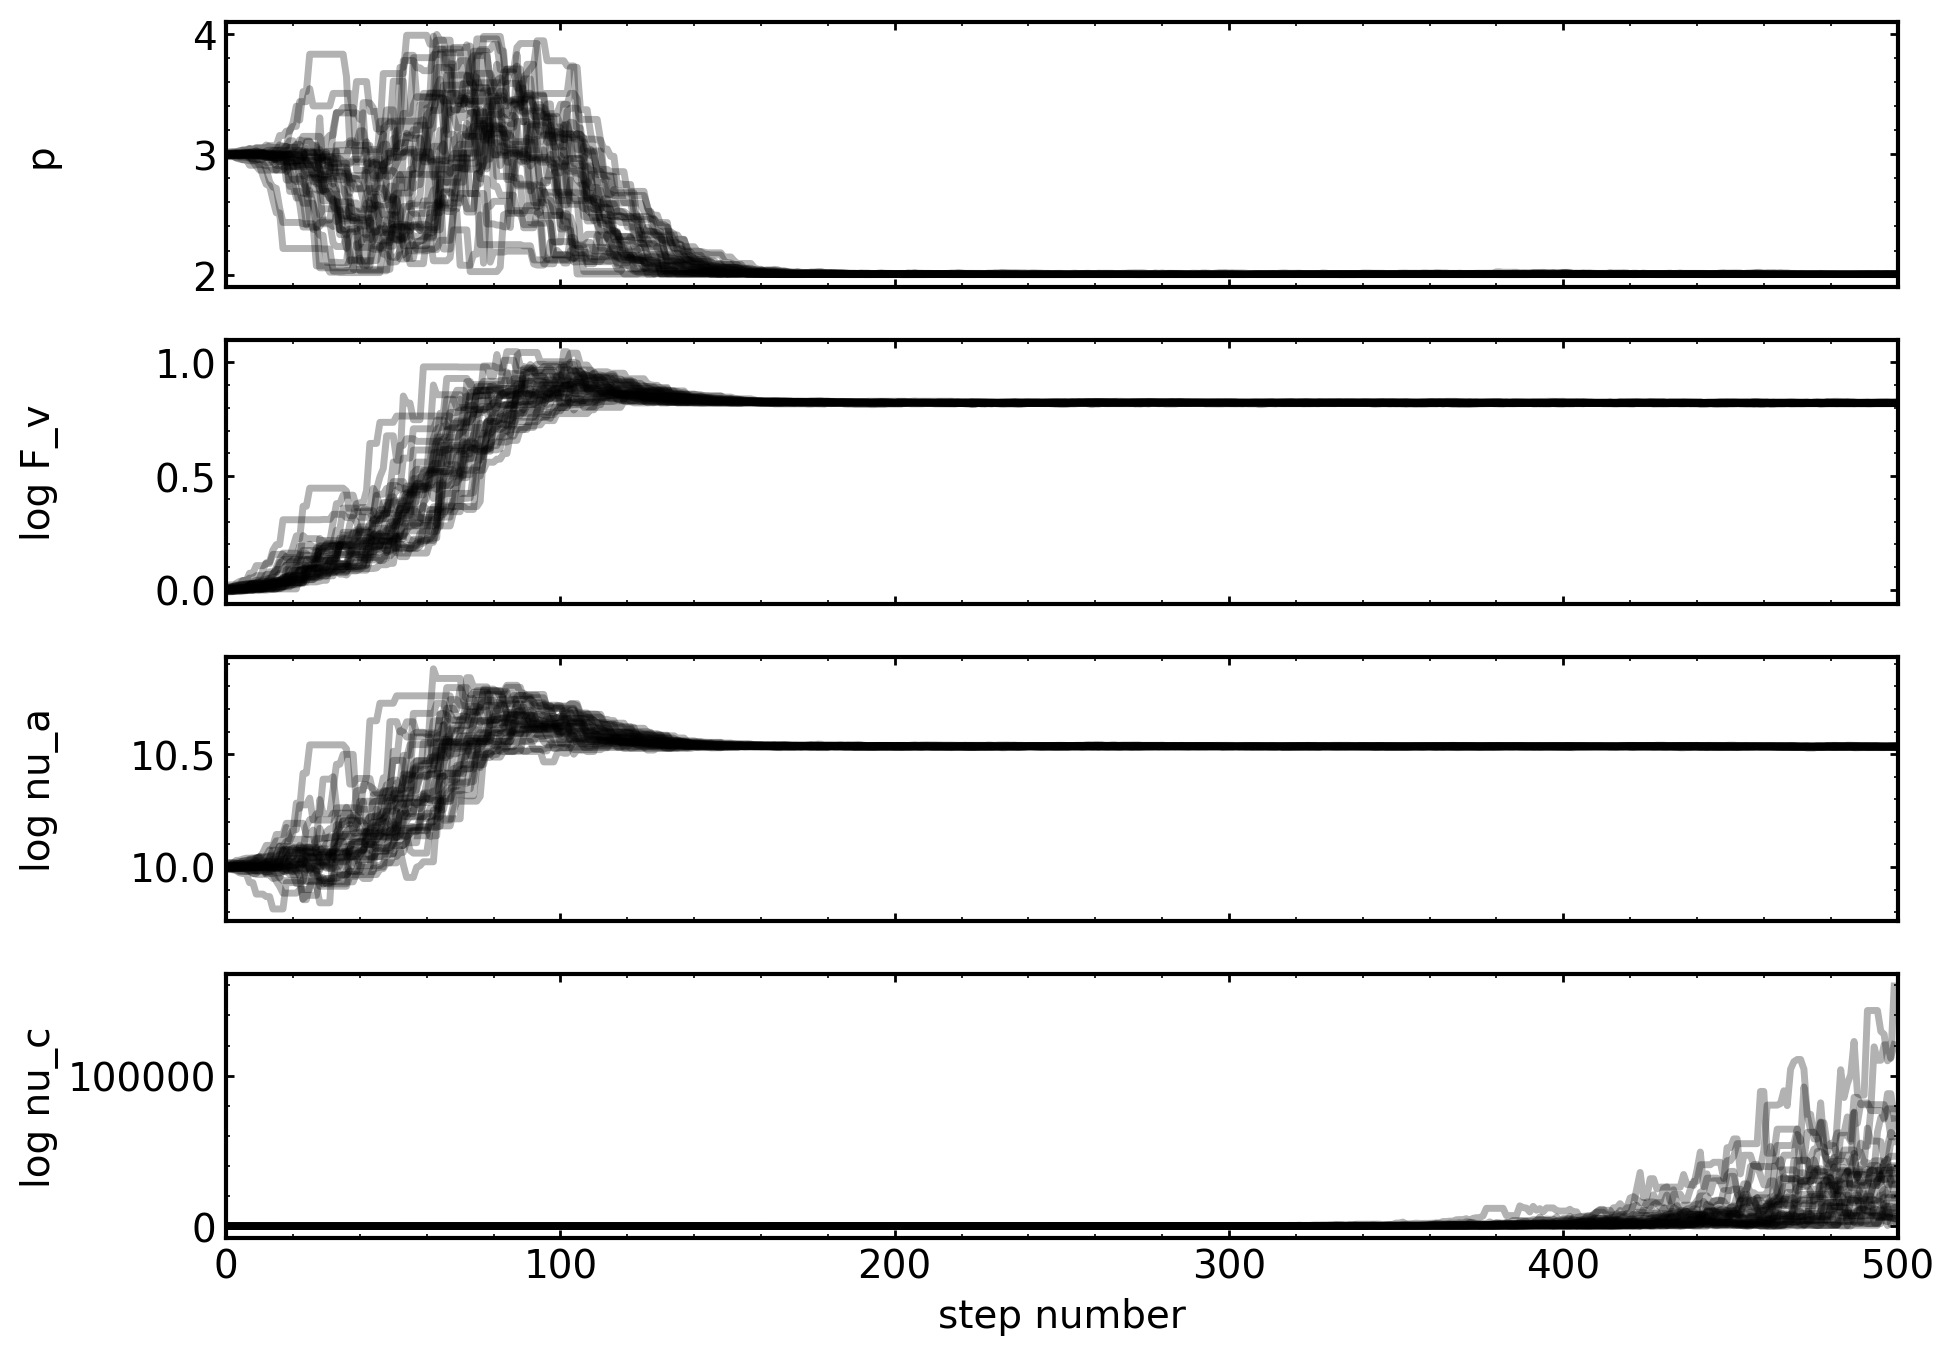

In [6]:
syncfit.analysis.plot_chains(sampler, labels)

And, it looks like they are well enough convered for the purposes of the tutorial. Finally, we can plot the fit and see what it looks like.

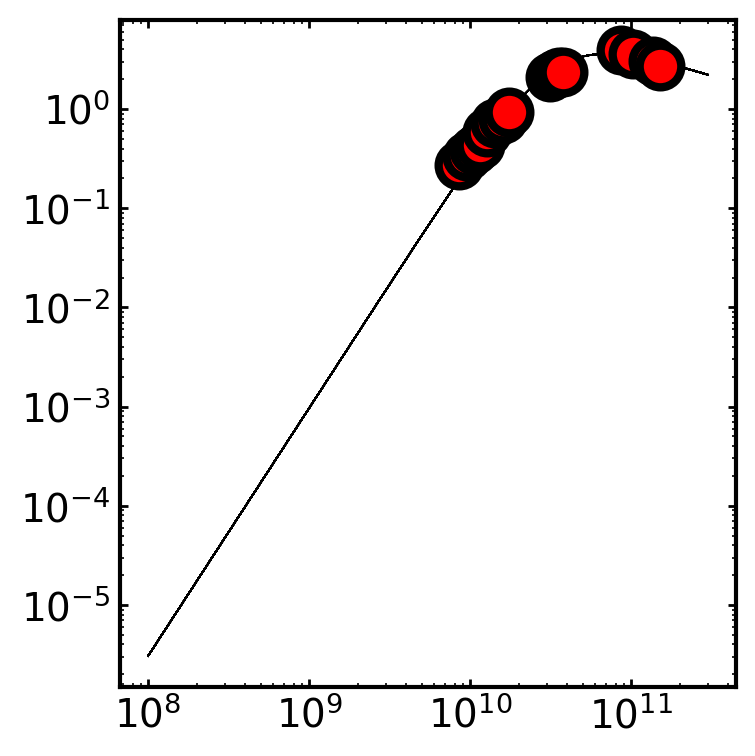

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
syncfit.analysis.plot_best_fit(
    model = syncfit.models.B5B3,
    sampler = sampler,
    
    # be careful with units for the data
    # the frequency must be in GHz space
    # and the flux densities must be in mJy space
    nu = cmc.nu*1e9,
    F = cmc.F_nu*1e-3
)

And look at that, the model looks great! Although, let's check if this is overfitting anything. Looking back at the output constraints, the nu_c and nu_a values appear suspiciously close to eachother. This is sometimes a clue that the model is overfitting the data by trying to make nu_a and nu_c the same value. 

### Using the B5 model
To try to remedy the overfitting, let's repeat our analysis but with just a self-absorption break. The builtin model that does this is the B5 model! The B5 model is very similar to the B5B3 model, we just have to provide only one initial guess for a break frequency in the `theta_init` definition.

In [8]:
# the initial guesses
theta_init = [
    3, # p-value guess
    0, # initial log_F_nu guess
    10, # initial nu_a guess, this is all we need for B5!
]

# the number of walkers
# 32 is usually fine, more makes it slower! 
nwalkers = 32

# now define the number of iterations
# something small for now to make it fast, 
# usually ~2000 gives a converging chaing
niter = 500

# now we can fit the data
sampler = syncfit.do_emcee(
    theta_init = theta_init,
    nu = cmc.nu,
    F_muJy = cmc.F_nu,
    F_error = cmc.F_err,
    model = syncfit.models.B5, # get the model from syncfit
    niter = niter,
    nwalkers = nwalkers
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2487.83it/s]


Finally, we can look at the outputs of all of the analysis tools, just like above!

\mathrm{p} = 2.00e+00_{-0.003}^{0.603}
\mathrm{log F_v} = 7.87e-01_{-0.008}^{0.004}
\mathrm{log nu_a} = 1.05e+01_{-0.005}^{0.004}


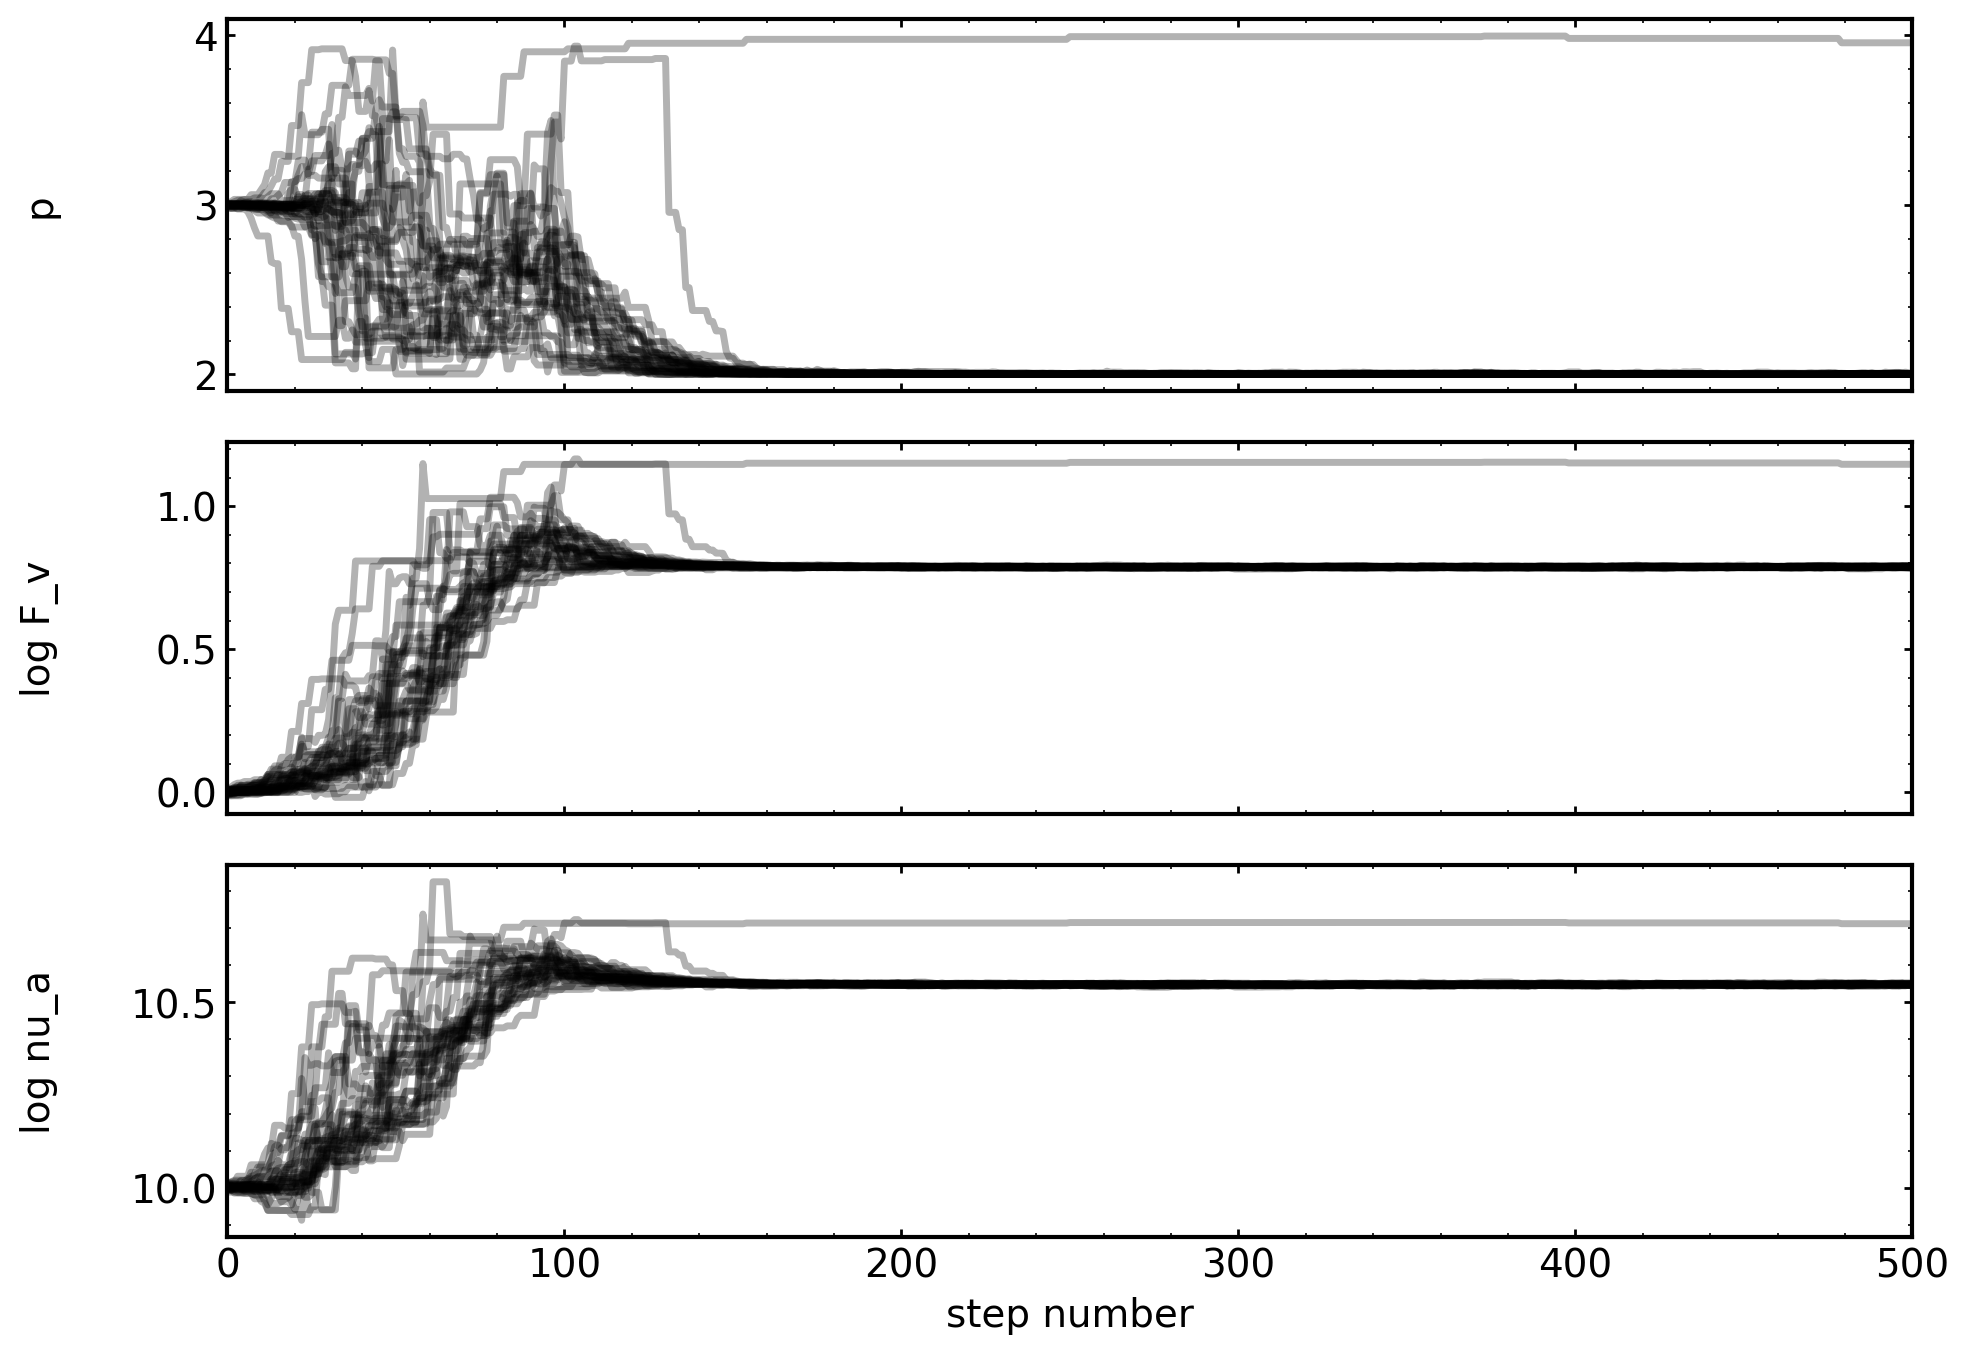

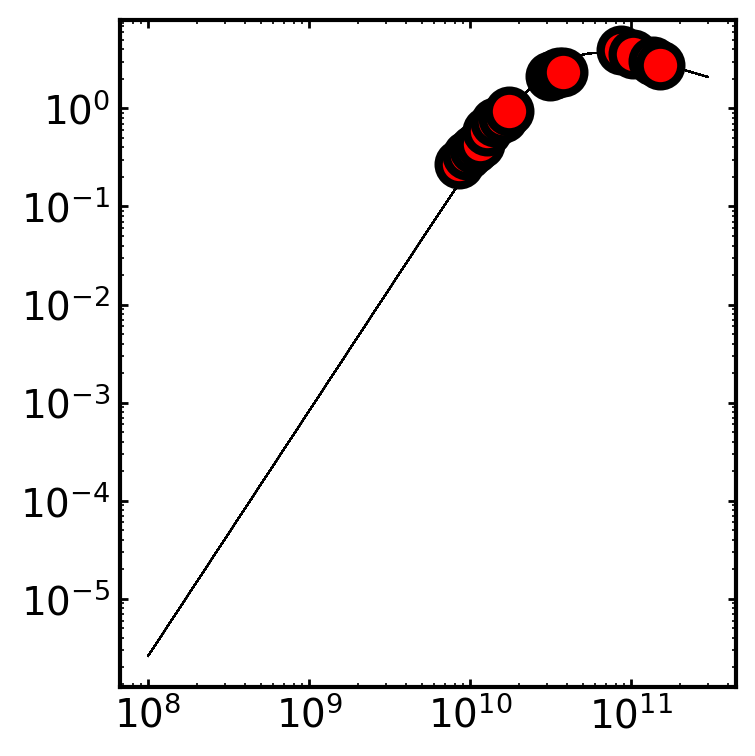

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
# get the chain labels from the model
labels = syncfit.models.B5.get_labels() 

constraints = syncfit.analysis.get_bounds(sampler, labels, toprint=True)

syncfit.analysis.plot_chains(sampler, labels)

syncfit.analysis.plot_best_fit(
    model = syncfit.models.B5,
    sampler = sampler,
    
    # be careful with units for the data
    # the frequency must be in GHz space
    # and the flux densities must be in mJy space
    nu = cmc.nu*1e9,
    F = cmc.F_nu*1e-3
)

Which also looks like a good fit! Although, the chain for `p` looks pretty poor. To remedy this, we can use the `fix_p` keyword to pick some fixed p-value and not fit for the power law p-value. For example, let's set `fix_p=3` and see what it all looks like.

In [10]:
# fit the data with a fixed p

# we need to redefine theta_init without
# an initial guess for p. The nwalkers
# and niters parameters can be left the same
theta_init_fixp = [
    0, # initial log_F_nu guess
    10, # initial nu_a guess, this is all we need for B5!
]

sampler = syncfit.do_emcee(
    theta_init = theta_init_fixp,
    nu = cmc.nu,
    F_muJy = cmc.F_nu,
    F_error = cmc.F_err,
    model = syncfit.models.B5, # get the model from syncfit
    niter = niter,
    nwalkers = nwalkers,
    fix_p = 3
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2346.14it/s]


\mathrm{log F_v} = 9.74e-01_{-0.005}^{0.002}
\mathrm{log nu_a} = 1.06e+01_{-0.002}^{0.002}


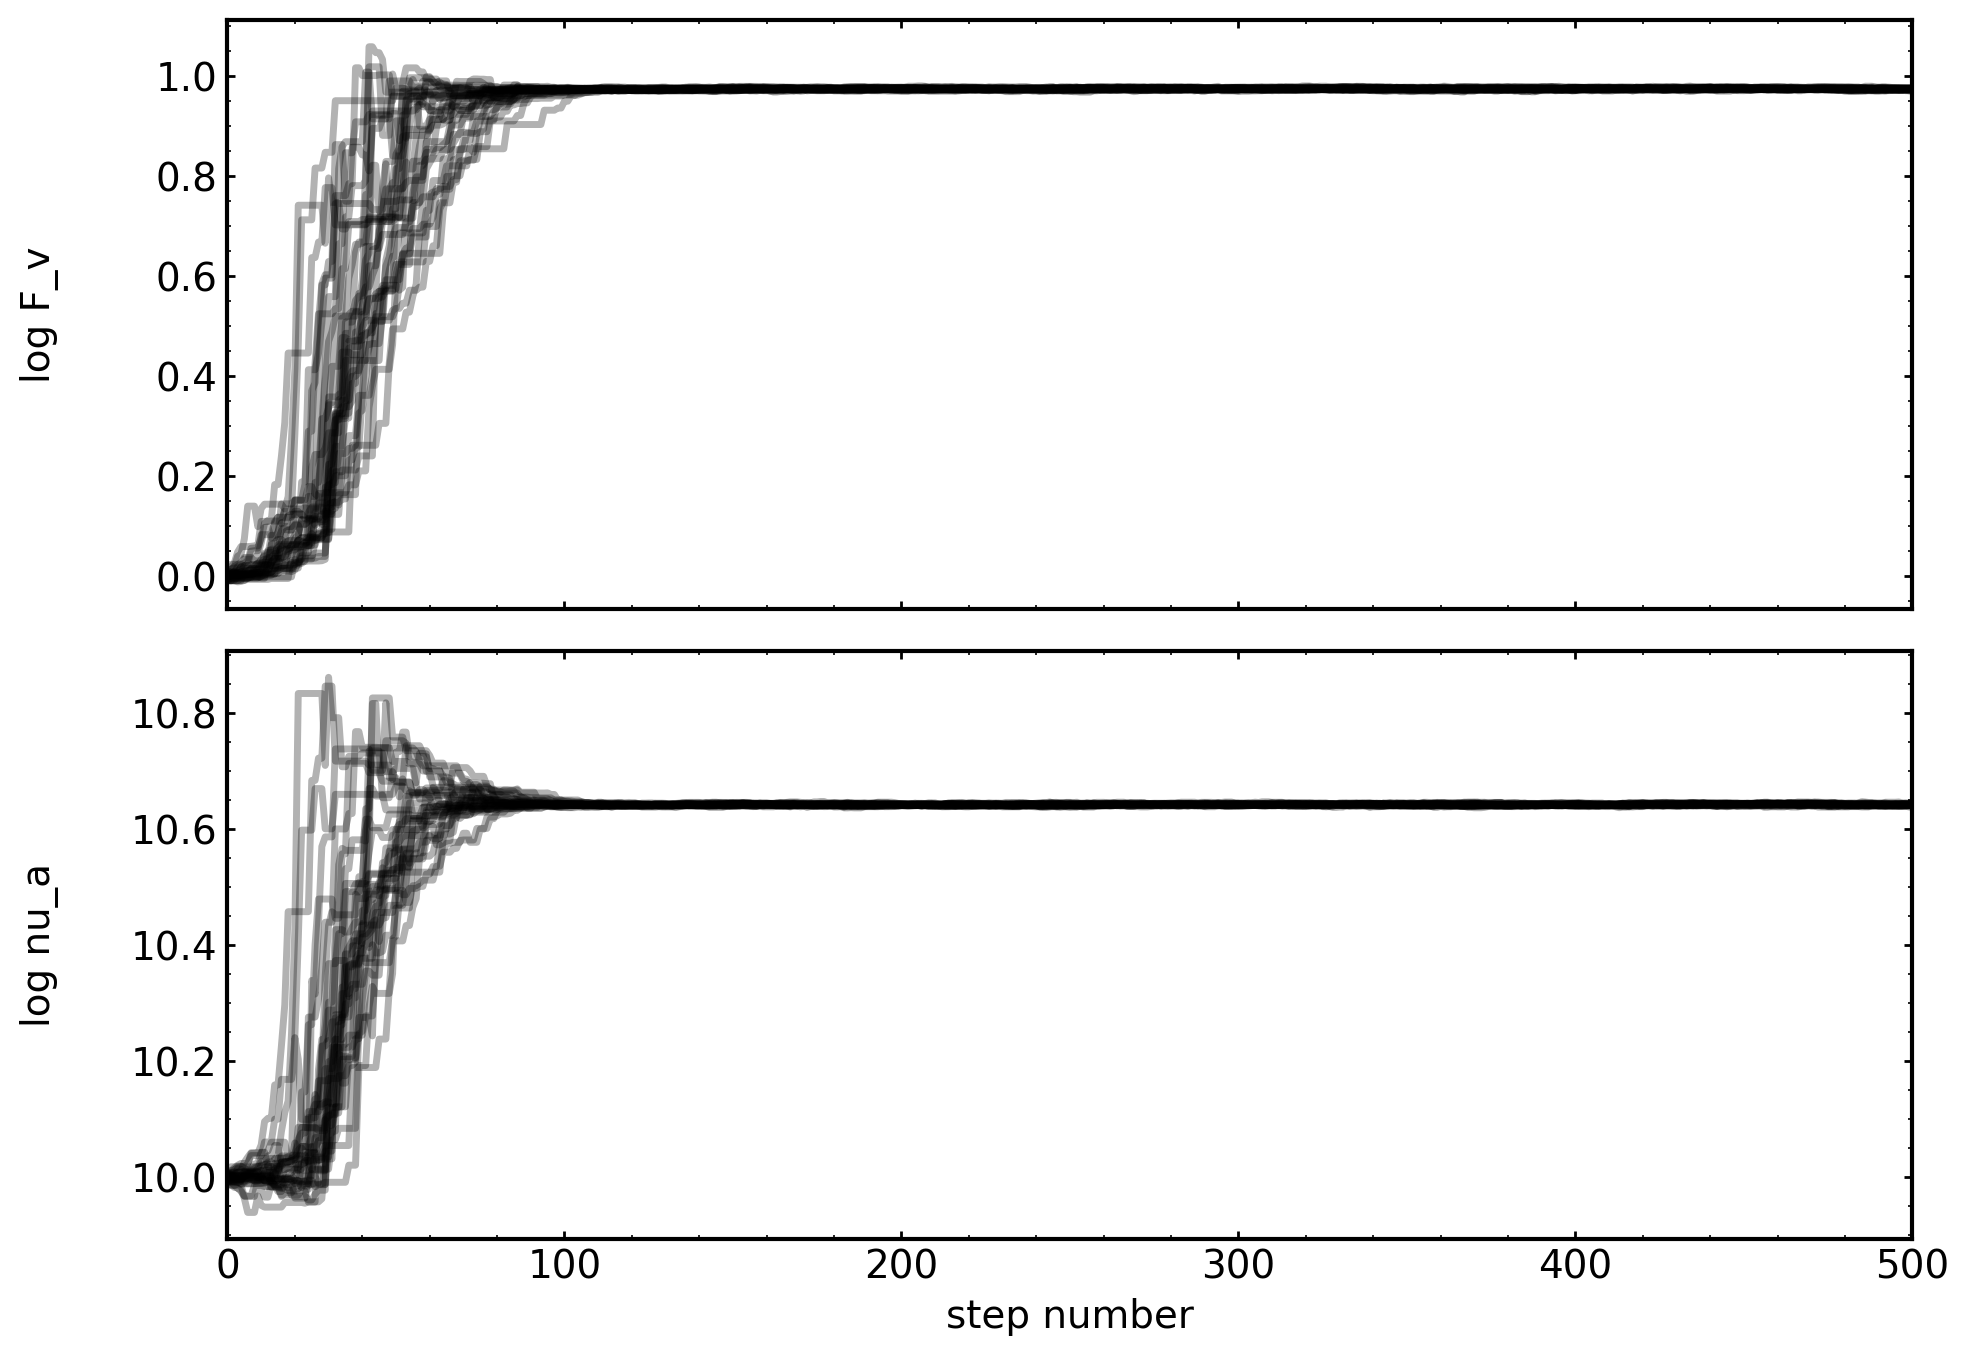

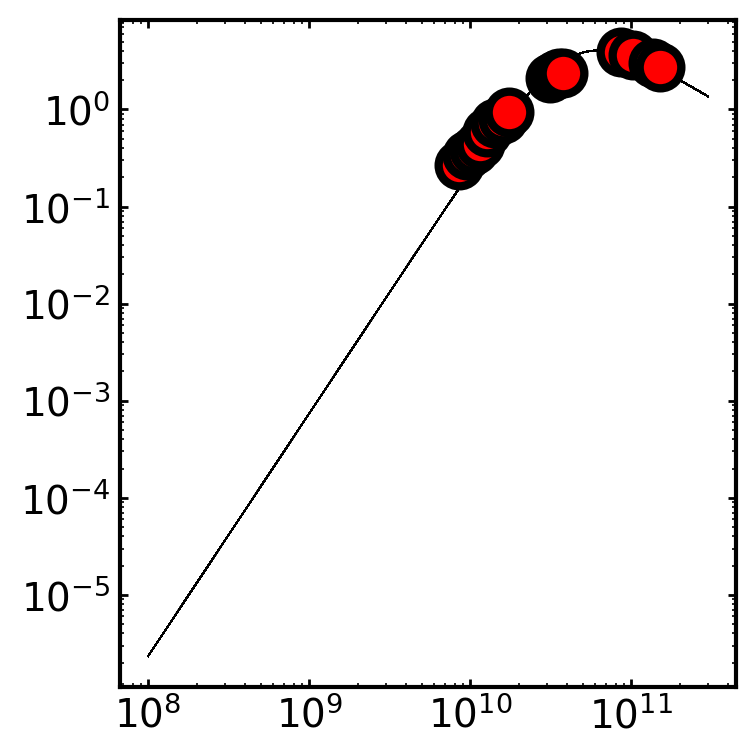

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [11]:
# get the chain labels from the model
labels = syncfit.models.B5B3.get_labels()
labels = labels[1:] # want to skip the first label since it is 'p'

constraints = syncfit.analysis.get_bounds(sampler, labels, toprint=True)

syncfit.analysis.plot_chains(sampler, labels)

syncfit.analysis.plot_best_fit(
    model = syncfit.models.B5,
    sampler = sampler,
    
    # be careful with units for the data
    # the frequency must be in GHz space
    # and the flux densities must be in mJy space
    nu = cmc.nu*1e9,
    F = cmc.F_nu*1e-3,
    
    # since we fixed p, we also need to give the
    # plot_best_fit function the p-value we used
    p = 3
)

Which has a fantastic looking fit and great looking chains! 

To see and understand all of the possible optional input arguments for, see the
source code documentation on the readthedocs page.